# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for XGBoost Model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [2]:
import os
import importlib
from library import etl_data as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.etl_data' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\classification_helper.py'>


In [3]:
!python -V

Python 3.10.6


# 1. Loading the data

In [4]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [5]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [6]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [7]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [8]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [9]:
# relevance table has the information about which feature is relevant for the classification task based on p-value

relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False


In [10]:
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [13]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [14]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [15]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [16]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

# 2. Hyperparameter optimization for XGBoost Model

In [18]:
from skmultilearn.problem_transform import BinaryRelevance
from xgboost import XGBClassifier

In [ ]:
parameters={'classifier__booster':['gbtree', 'dart'], 'classifier__eta':[0.25, 0.3, 0.35],
            'classifier__max_depth':[20,80,200], 'classifier__min_child_weight':[1,4,8], 
            'classifier__n_estimators':[100,150,200]}

search = GridSearchCV(BinaryRelevance(XGBClassifier()), parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5; 1/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 1/5; 1/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.868 total time=   8.6s
[CV 2/5; 1/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 2/5; 1/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.865 total time=   8.5s
[CV 3/5; 1/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 3/5; 1/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier

[CV 4/5; 5/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.855 total time=   7.2s
[CV 5/5; 5/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 5/5; 5/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.858 total time=   7.2s
[CV 1/5; 6/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 1/5; 6/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.858 total time=   8.3s
[CV 2/5; 6/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=20, classifier__mi

[CV 3/5; 10/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.887 total time=   8.5s
[CV 4/5; 10/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 4/5; 10/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.884 total time=   8.4s
[CV 5/5; 10/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 5/5; 10/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.858 total time=   8.6s
[CV 1/5; 11/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifi

[CV 2/5; 15/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.874 total time=   8.2s
[CV 3/5; 15/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 3/5; 15/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.897 total time=   8.3s
[CV 4/5; 15/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 4/5; 15/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.855 total time=   8.2s
[CV 5/5; 15/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=80, classifi

[CV 1/5; 20/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.868 total time=   9.7s
[CV 2/5; 20/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150
[CV 2/5; 20/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.868 total time=   9.7s
[CV 3/5; 20/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150
[CV 3/5; 20/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.890 total time=   9.9s
[CV 4/5; 20/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, cl

[CV 5/5; 24/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.855 total time=   8.3s
[CV 1/5; 25/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 1/5; 25/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.858 total time=   5.1s
[CV 2/5; 25/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 2/5; 25/162] END classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.868 total time=   5.2s
[CV 3/5; 25/162] START classifier__booster=gbtree, classifier__eta=0.25, classifier__max_depth=200, cl

[CV 4/5; 29/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.877 total time=   8.9s
[CV 5/5; 29/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=150
[CV 5/5; 29/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.848 total time=   8.9s
[CV 1/5; 30/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200
[CV 1/5; 30/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.868 total time=  10.0s
[CV 2/5; 30/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__mi

[CV 3/5; 34/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.868 total time=   4.9s
[CV 4/5; 34/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 4/5; 34/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.839 total time=   4.9s
[CV 5/5; 34/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 5/5; 34/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.845 total time=   4.8s
[CV 1/5; 35/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=20, classifier__mi

[CV 2/5; 39/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.877 total time=  10.0s
[CV 3/5; 39/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=200
[CV 3/5; 39/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.890 total time=  10.1s
[CV 4/5; 39/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=200
[CV 4/5; 39/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.874 total time=  10.0s
[CV 5/5; 39/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__mi

[CV 1/5; 44/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.852 total time=   5.8s
[CV 2/5; 44/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150
[CV 2/5; 44/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.881 total time=   5.9s
[CV 3/5; 44/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150
[CV 3/5; 44/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.871 total time=   5.8s
[CV 4/5; 44/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=80, classifier__mi

[CV 5/5; 48/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.848 total time=  10.2s
[CV 1/5; 49/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 1/5; 49/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.858 total time=   5.5s
[CV 2/5; 49/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 2/5; 49/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.874 total time=   5.6s
[CV 3/5; 49/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifi

[CV 4/5; 53/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.848 total time=   5.8s
[CV 5/5; 53/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=150
[CV 5/5; 53/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.848 total time=   5.9s
[CV 1/5; 54/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200
[CV 1/5; 54/162] END classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.855 total time=   6.7s
[CV 2/5; 54/162] START classifier__booster=gbtree, classifier__eta=0.3, classifier__max_depth=200, classifi

[CV 3/5; 58/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.881 total time=   5.3s
[CV 4/5; 58/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 4/5; 58/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.855 total time=   5.1s
[CV 5/5; 58/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 5/5; 58/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.861 total time=   5.2s
[CV 1/5; 59/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifi

[CV 2/5; 63/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.874 total time=   7.3s
[CV 3/5; 63/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=200
[CV 3/5; 63/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.865 total time=   6.5s
[CV 4/5; 63/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=200
[CV 4/5; 63/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.852 total time=   7.1s
[CV 5/5; 63/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=20, classifi

[CV 1/5; 68/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.868 total time=   6.2s
[CV 2/5; 68/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 2/5; 68/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.865 total time=   6.2s
[CV 3/5; 68/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 3/5; 68/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.884 total time=   6.2s
[CV 4/5; 68/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifi

[CV 5/5; 72/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.835 total time=   6.4s
[CV 1/5; 73/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 1/5; 73/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.858 total time=   7.0s
[CV 2/5; 73/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 2/5; 73/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.874 total time=   7.0s
[CV 3/5; 73/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, cla

[CV 4/5; 77/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.855 total time=   6.2s
[CV 5/5; 77/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 5/5; 77/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.865 total time=   6.3s
[CV 1/5; 78/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 1/5; 78/162] END classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.868 total time=   7.2s
[CV 2/5; 78/162] START classifier__booster=gbtree, classifier__eta=0.35, classifier__max_depth=200, cl

[CV 3/5; 82/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.887 total time=  45.3s
[CV 4/5; 82/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 4/5; 82/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.884 total time=  44.0s
[CV 5/5; 82/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 5/5; 82/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.858 total time=  44.2s
[CV 1/5; 83/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_chil

[CV 2/5; 87/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.874 total time= 2.7min
[CV 3/5; 87/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 3/5; 87/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.897 total time= 2.7min
[CV 4/5; 87/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 4/5; 87/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.855 total time= 2.7min
[CV 5/5; 87/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=20, classifier__min_chil

[CV 1/5; 92/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.868 total time= 1.6min
[CV 2/5; 92/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=150
[CV 2/5; 92/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.868 total time= 1.6min
[CV 3/5; 92/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=150
[CV 3/5; 92/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.890 total time= 1.6min
[CV 4/5; 92/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_chil

[CV 5/5; 96/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.855 total time= 2.7min
[CV 1/5; 97/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 1/5; 97/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.858 total time=  43.2s
[CV 2/5; 97/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 2/5; 97/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.868 total time=  43.5s
[CV 3/5; 97/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=80, classifier__min_chil

[CV 4/5; 101/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.887 total time= 1.6min
[CV 5/5; 101/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150
[CV 5/5; 101/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=150;, score=0.861 total time= 1.6min
[CV 1/5; 102/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=200
[CV 1/5; 102/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.868 total time= 2.7min
[CV 2/5; 102/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifi

[CV 3/5; 106/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.868 total time=  43.9s
[CV 4/5; 106/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 4/5; 106/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.861 total time=  44.8s
[CV 5/5; 106/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100
[CV 5/5; 106/162] END classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=100;, score=0.845 total time=  54.1s
[CV 1/5; 107/162] START classifier__booster=dart, classifier__eta=0.25, classifier__max_depth=200, classifi

[CV 2/5; 111/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.877 total time= 2.7min
[CV 3/5; 111/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200
[CV 3/5; 111/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.890 total time= 2.7min
[CV 4/5; 111/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200
[CV 4/5; 111/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.874 total time=12.4min
[CV 5/5; 111/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_chil

[CV 1/5; 116/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.852 total time= 1.4min
[CV 2/5; 116/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=150
[CV 2/5; 116/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.881 total time= 1.4min
[CV 3/5; 116/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=150
[CV 3/5; 116/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.871 total time= 1.4min
[CV 4/5; 116/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=20, classifier__min_chil

[CV 5/5; 120/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=200;, score=0.848 total time= 2.4min
[CV 1/5; 121/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 1/5; 121/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.858 total time=  40.4s
[CV 2/5; 121/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 2/5; 121/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.874 total time=  40.1s
[CV 3/5; 121/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_chil

[CV 4/5; 125/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.848 total time= 1.4min
[CV 5/5; 125/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150
[CV 5/5; 125/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=150;, score=0.848 total time= 1.4min
[CV 1/5; 126/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=200
[CV 1/5; 126/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.855 total time= 2.4min
[CV 2/5; 126/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=80, classifier__min_chil

[CV 3/5; 130/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.881 total time=  41.4s
[CV 4/5; 130/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 4/5; 130/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.874 total time=  41.2s
[CV 5/5; 130/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100
[CV 5/5; 130/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=4, classifier__n_estimators=100;, score=0.855 total time=  40.5s
[CV 1/5; 131/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__mi

[CV 2/5; 135/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.881 total time= 2.4min
[CV 3/5; 135/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200
[CV 3/5; 135/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.871 total time= 2.4min
[CV 4/5; 135/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200
[CV 4/5; 135/162] END classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.845 total time= 2.4min
[CV 5/5; 135/162] START classifier__booster=dart, classifier__eta=0.3, classifier__max_depth=200, classifier__mi

[CV 1/5; 140/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.868 total time= 1.4min
[CV 2/5; 140/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 2/5; 140/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.865 total time= 1.4min
[CV 3/5; 140/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 3/5; 140/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.884 total time= 1.4min
[CV 4/5; 140/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__mi

[CV 5/5; 144/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=20, classifier__min_child_weight=8, classifier__n_estimators=200;, score=0.835 total time= 2.4min
[CV 1/5; 145/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 1/5; 145/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.858 total time=  41.5s
[CV 2/5; 145/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 2/5; 145/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.874 total time=  42.1s
[CV 3/5; 145/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__mi

[CV 4/5; 149/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.855 total time= 1.4min
[CV 5/5; 149/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150
[CV 5/5; 149/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=150;, score=0.865 total time= 1.4min
[CV 1/5; 150/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200
[CV 1/5; 150/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__min_child_weight=4, classifier__n_estimators=200;, score=0.868 total time= 2.4min
[CV 2/5; 150/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=80, classifier__mi

[CV 3/5; 154/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.900 total time=  41.7s
[CV 4/5; 154/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 4/5; 154/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.871 total time=  41.7s
[CV 5/5; 154/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100
[CV 5/5; 154/162] END classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=200, classifier__min_child_weight=1, classifier__n_estimators=100;, score=0.858 total time=  41.8s
[CV 1/5; 155/162] START classifier__booster=dart, classifier__eta=0.35, classifier__max_depth=200, classifi

In [28]:
results = pd.DataFrame(search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.804171,0.076235,0.093064,0.006118,gini,20,sqrt,0.0,1,2,50,"{'classifier__criterion': 'gini', 'classifier_...",0.845161,0.835484,0.854839,0.845161,0.838710,0.843871,0.006642,317
1,7.922959,0.760167,0.156610,0.014453,gini,20,sqrt,0.0,1,2,100,"{'classifier__criterion': 'gini', 'classifier_...",0.848387,0.829032,0.851613,0.854839,0.838710,0.844516,0.009438,296
2,14.869952,0.101978,0.249983,0.009881,gini,20,sqrt,0.0,1,2,200,"{'classifier__criterion': 'gini', 'classifier_...",0.854839,0.832258,0.854839,0.854839,0.848387,0.849032,0.008751,215
3,3.772478,0.040277,0.099998,0.012504,gini,20,sqrt,0.0,1,4,50,"{'classifier__criterion': 'gini', 'classifier_...",0.861290,0.829032,0.845161,0.841935,0.845161,0.844516,0.010282,296
4,7.484771,0.140846,0.153120,0.011693,gini,20,sqrt,0.0,1,4,100,"{'classifier__criterion': 'gini', 'classifier_...",0.845161,0.829032,0.864516,0.848387,0.841935,0.845806,0.011432,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,4.048892,0.043557,0.149995,0.012502,entropy,200,log2,0.001,8,4,100,"{'classifier__criterion': 'entropy', 'classifi...",0.822581,0.835484,0.832258,0.832258,0.816129,0.827742,0.007242,619
968,7.961349,0.076645,0.249978,0.013976,entropy,200,log2,0.001,8,4,200,"{'classifier__criterion': 'entropy', 'classifi...",0.816129,0.835484,0.835484,0.829032,0.819355,0.827097,0.008058,628
969,2.068607,0.033650,0.103117,0.007653,entropy,200,log2,0.001,8,8,50,"{'classifier__criterion': 'entropy', 'classifi...",0.822581,0.812903,0.838710,0.822581,0.835484,0.826452,0.009438,638
970,3.990343,0.037755,0.162491,0.015932,entropy,200,log2,0.001,8,8,100,"{'classifier__criterion': 'entropy', 'classifi...",0.816129,0.835484,0.829032,0.835484,0.819355,0.827097,0.008058,636


In [29]:
results.sort_values(by=["rank_test_score"]).iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
706,8.652521,0.043515,0.140611,0.009876,entropy,80,sqrt,0.001,1,4,100,"{'classifier__criterion': 'entropy', 'classifi...",0.864516,0.854839,0.887097,0.870968,0.867742,0.869032,0.010522,1
866,17.367532,0.184497,0.237485,0.011694,entropy,200,sqrt,0.001,1,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.877419,0.848387,0.870968,0.877419,0.870968,0.869032,0.010718,2
542,17.383159,0.039019,0.246856,0.011690,entropy,20,sqrt,0.001,1,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.858065,0.874194,0.877419,0.858065,0.868387,0.008510,3
871,8.630642,0.139951,0.153120,0.011696,entropy,200,sqrt,0.001,1,8,100,"{'classifier__criterion': 'entropy', 'classifi...",0.880645,0.838710,0.880645,0.874194,0.867742,0.868387,0.015591,3
490,8.582192,0.069452,0.146873,0.007660,entropy,20,sqrt,0.0,1,4,100,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.845161,0.870968,0.874194,0.874194,0.867742,0.011359,5
811,8.677517,0.129070,0.143737,0.011688,entropy,200,sqrt,0.0,1,2,100,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.848387,0.883871,0.874194,0.858065,0.867742,0.012741,5
675,4.362200,0.087496,0.103110,0.007661,entropy,80,sqrt,0.0001,1,2,50,"{'classifier__criterion': 'entropy', 'classifi...",0.870968,0.851613,0.864516,0.880645,0.867742,0.867097,0.009438,7
872,17.186475,0.123154,0.240606,0.007653,entropy,200,sqrt,0.001,1,8,200,"{'classifier__criterion': 'entropy', 'classifi...",0.877419,0.851613,0.870968,0.877419,0.858065,0.867097,0.010483,7
842,17.400908,0.169330,0.246859,0.018222,entropy,200,sqrt,0.0001,1,4,200,"{'classifier__criterion': 'entropy', 'classifi...",0.874194,0.851613,0.867742,0.870968,0.867742,0.866452,0.007796,9
650,17.732731,0.102762,0.253105,0.011692,entropy,80,sqrt,0.0,1,2,200,"{'classifier__criterion': 'entropy', 'classifi...",0.870968,0.858065,0.877419,0.874194,0.851613,0.866452,0.009911,9


In [30]:
best_clf = search.best_estimator_
best_clf

BinaryRelevance(classifier=RandomForestClassifier(criterion='entropy',
                                                  max_depth=80,
                                                  min_impurity_decrease=0.001,
                                                  min_samples_split=4),
                require_dense=[True, True])

# 3. Evaluation of optimized model and saving the results

In [45]:
#with open('model/mlc_ml_br_randomforest_v2.4.pkl', 'wb') as f:
#    pickle.dump(best_clf, f)

In [18]:
with open('model/mlc_ml_br_xgboost_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [22]:
best_clf.get_params

<bound method MLClassifierBase.get_params of BinaryRelevance(classifier=XGBClassifier(base_score=None, booster='gbtree',
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False, eta=0.25,
                                         eval_metric=None, feature_types=None,
                                         gamma=None, gpu_id=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                      

In [26]:
y_pred = best_clf.predict(x_test)
y_pred = y_pred.toarray()
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [27]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.8666666666666667
hamming loss: 0.020833333333333332

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.969     0.940     0.954       100
           2      0.963     0.910     0.936       200
           3      0.985     0.975     0.980       200
           4      0.952     0.790     0.863       100
           5      0.963     0.867     0.912       150
           6      0.973     0.960     0.966       150
           7      0.975     0.932     0.953       250

   micro avg      0.972     0.922     0.947      1200
   macro avg      0.972     0.922     0.946      1200
weighted avg      0.971     0.922     0.946      1200
 samples avg      0.959     0.933     0.939      1200



In [28]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,14,16,24,25,26,27,35,37,47,57,67,246,247,267,357,3567,noclass,Total
True,,,,,,,,,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50
2,0,2,43,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,50
3,0,0,0,49,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,0,0,39,0,0,1,0,0,6,0,1,0,0,0,1,1,0,0,0,0,0,0,1,50
5,0,0,0,1,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,1,0,0,47,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,50
16,0,4,0,0,0,0,4,0,1,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50


In [29]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[700,   0],
        [  0,  50]],

       [[647,   3],
        [  6,  94]],

       [[543,   7],
        [ 18, 182]],

       [[547,   3],
        [  5, 195]],

       [[646,   4],
        [ 21,  79]],

       [[595,   5],
        [ 20, 130]],

       [[596,   4],
        [  6, 144]],

       [[494,   6],
        [ 17, 233]]], dtype=int64)

In [31]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [32]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

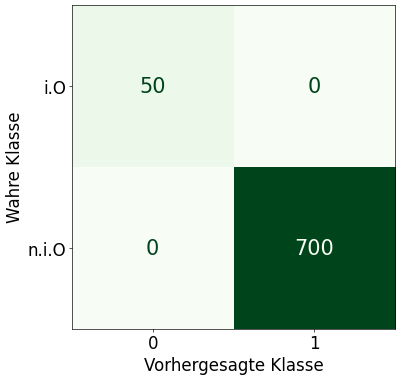

In [34]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [35]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [39]:
res = collect_results(best_clf, y_test, y_pred, algorithm="xgboost", params=parameters, best_param=best_clf.get_params)
res

{'algorithm': 'xgboost',
 'params': {'classifier__booster': ['gbtree', 'dart'],
  'classifier__eta': [0.25, 0.3, 0.35],
  'classifier__max_depth': [20, 80, 200],
  'classifier__min_child_weight': [1, 4, 8],
  'classifier__n_estimators': [100, 150, 200]},
 'best_param': <bound method MLClassifierBase.get_params of BinaryRelevance(classifier=XGBClassifier(base_score=None, booster='gbtree',
                                          callbacks=None, colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.25,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None, importance_type=None,
                    

In [40]:
filename = "mlc_ml_br_hyperopt_results_v2.4.json"
key_algorithm = "xgb"
hyperopt_result = res

In [44]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()